In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##  Preferrably Run on Kaggle!!

# Importing Dependencies

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys
import re
import string

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.utils.class_weight import compute_class_weight
import nltk
import optuna

In [5]:
from transformers import BertTokenizer, BertModel

Downloading Necessary packages

In [6]:
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopword removal
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Preprocessing Method for Plot Synopsis

In [7]:
def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r"[^ a-zA-Z]", ' ',text)             # only keeps characters
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i)>1]) # keep words with length>1 only
    return text

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [9]:
train_df = pd.read_csv('/kaggle/input/cw2-training-dataset/CW2-training-dataset.csv')

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8257 entries, 0 to 8256
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             8257 non-null   object
 1   title          8257 non-null   object
 2   plot_synopsis  8257 non-null   object
 3   comedy         8257 non-null   int64 
 4   cult           8257 non-null   int64 
 5   flashback      8257 non-null   int64 
 6   historical     8257 non-null   int64 
 7   murder         8257 non-null   int64 
 8   revenge        8257 non-null   int64 
 9   romantic       8257 non-null   int64 
 10  scifi          8257 non-null   int64 
 11  violence       8257 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 774.2+ KB


## Data Visualization

In [11]:
bar_plot = pd.DataFrame()
bar_plot['cat'] = train_df.columns[3:]
bar_plot['count'] = train_df.iloc[:,3:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head(9)

,cat,count
0,murder,4019
1,violence,3064
2,romantic,2006
3,flashback,1994
4,cult,1801
5,revenge,1657
6,comedy,1262
7,scifi,204
8,historical,186


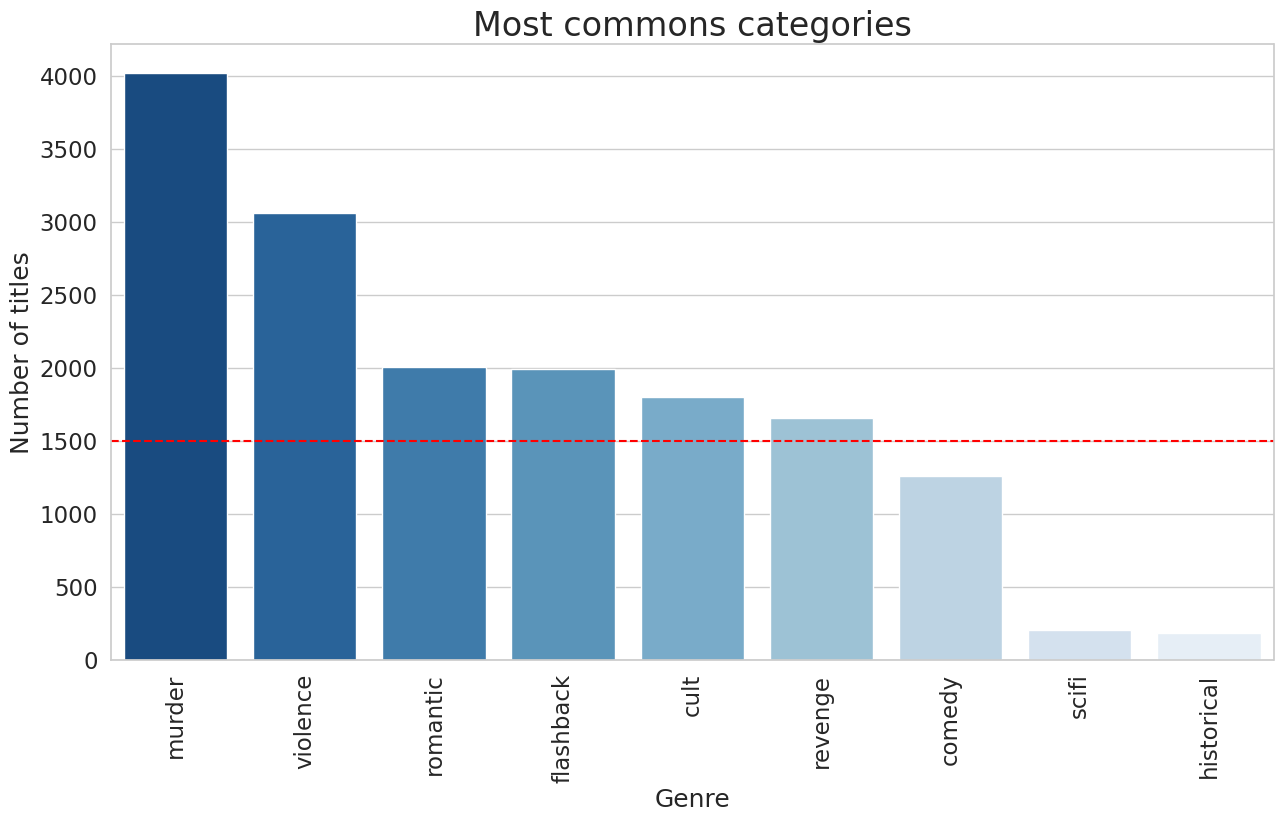

In [12]:
threshold = 1500
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')


pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()

sns.barplot(x='cat',
    y='count',
    data=bar_plot,
    palette=np.array(pal[::-1])[rank])

plt.axhline(threshold, ls='--', c='red')
plt.title("Most commons categories", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

In [13]:
train_df = train_df.drop(['ID', 'title'],axis= 1)
train_df.columns

Index(['plot_synopsis', 'comedy', 'cult', 'flashback', 'historical', 'murder',
       'revenge', 'romantic', 'scifi', 'violence'],
      dtype='object')

In [14]:
train_df['plot_synopsis'] = train_df['plot_synopsis'].apply(clean_text)

In [17]:
train_df.head(2)

,plot_synopsis,comedy,cult,flashback,historical,murder,revenge,romantic,scifi,violence
0,recent amount challenges billy lo bruce lee fr...,0,0,0,0,1,1,0,0,1
1,crime ridden city tremont renowned investigati...,0,0,0,0,1,1,1,0,1


In [18]:
target_list = ['comedy', 'cult', 'flashback', 'historical', 'murder',
       'revenge', 'romantic', 'scifi', 'violence']

## Calculating Weights for handling class imbalance

In [19]:
class_weights = []

for i, label in enumerate(target_list):
    label_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = [0,1],
        y = train_df[label].values
    )
    class_weights.append(label_weights[1])

weights_tensor = torch.tensor(class_weights, dtype = torch.float).to(device)

In [20]:
weights_tensor

tensor([ 3.2714,  2.2923,  2.0705, 22.1962,  1.0272,  2.4916,  2.0581, 20.2377,
         1.3474], device='cuda:0')

In [21]:
# hyperparameters obtained through Bayesian Optimization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-05

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['plot_synopsis']
        self.targets = self.df[target_list].values.astype(np.float32)
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }


## Preparing Validation Set

In [27]:
val_df = pd.read_csv('/kaggle/input/cw2-validation-dataset/CW2-validation-dataset.csv')
first_column = val_df.iloc[:, 0]
first_column

0       cf32cb00-172d-40f2-a3c1-936e8a0d89d7
1       df7e125e-2d59-40e4-a126-9397e3a0ef21
2       49bc73f3-9179-41cd-9774-905c7a3ac91b
3       0ed4822b-87af-44bc-a677-7f7abfdaccf3
4       0b1b0fa4-43bc-41ba-9598-b3401894b96d
                        ...                 
1183    d32be875-41c7-4e84-ac04-e1d3bc3df0fe
1184    84e025dd-4b4e-403c-a3dd-34818b210857
1185    3d291d3b-c0b5-47cc-8dc8-127dc93162e3
1186    6c9b3034-56b3-42f6-874e-a821c9fd1a89
1187    fbd1d334-e979-465c-9fb0-e173d2642630
Name: ID, Length: 1188, dtype: object

In [28]:
val_df = val_df.drop(['ID', 'title'],axis= 1)
val_df['plot_synopsis'] = val_df['plot_synopsis'].apply(clean_text)

In [29]:
val_df.head(2)

,plot_synopsis,comedy,cult,flashback,historical,murder,revenge,romantic,scifi,violence
0,enchanting city verona italy renowned painter ...,0,0,0,0,1,0,1,0,0
1,walker works friend mal reese steal large amou...,0,1,1,0,1,1,0,0,1


In [30]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN, target_list=target_list)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN, target_list=target_list)

In [31]:
len(train_dataset)

8257

In [32]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [33]:
len(train_data_loader)

517

In [34]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 9)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        # output_dropout = self.dropout(output.pooler_output)
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [35]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss(pos_weight = weights_tensor)(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

## Bayesian Optimization to get best possible hyperparameters.

In [58]:
def objective(trial):
    # Define hyperparameter search space
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 2e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    # Initialize model, optimizer, and tokenizer
    dropout_rate = 0.5
    model = BERTClass().to(device)
    model.dropout.p = dropout_rate
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # DataLoaders (define your training_loader and validation_loader here)
    training_loader = train_data_loader
    validation_loader = val_data_loader

    # Training loop setup
    n_epochs = 2  # Number of epochs for this trial
    valid_loss_min = np.Inf

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, data in enumerate(training_loader):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            weighted_targets = targets * weights_tensor
            outputs = model(ids, mask, token_type_ids)
            optimizer.zero_grad()
            loss = loss_fn(outputs, weighted_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader):
                ids = data['input_ids'].to(device, dtype=torch.long)
                mask = data['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
                targets = data['targets'].to(device, dtype=torch.float)
                
                weighted_targets = targets * weights_tensor
                outputs = model(ids, mask, token_type_ids)
                loss = loss_fn(outputs, weighted_targets)
                valid_loss += loss.item()

        # Calculate average validation loss
        valid_loss /= len(validation_loader)

        # Update minimum validation loss
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss

    return valid_loss_min


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)


[I 2024-11-26 03:53:28,983] A new study created in memory with name: no-name-ed544931-c4f5-478d-9366-17b1a33e099d
[I 2024-11-26 04:11:01,765] Trial 0 finished with value: 0.7416231871644656 and parameters: {'learning_rate': 1.5623344958868598e-05, 'batch_size': 16}. Best is trial 0 with value: 0.7416231871644656.
[I 2024-11-26 04:28:37,270] Trial 1 finished with value: 0.6212344391271472 and parameters: {'learning_rate': 1.3367623645529437e-05, 'batch_size': 16}. Best is trial 1 with value: 0.6212344391271472.
[W 2024-11-26 04:36:49,033] Trial 2 failed with parameters: {'learning_rate': 1.5315518502910087e-05, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_30/1869258477.py", line 38, in objective
    train_loss += loss.item()
KeyboardInterrupt


# Training BERT

In [36]:
val_targets=[]
val_outputs=[]

In [37]:
def train_model(n_epochs, training_loader, validation_loader, model,
                optimizer):

  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf


  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        # print(type(data['targets']))
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if batch_idx%100==0:
           print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        loss.backward()
        optimizer.step()
        # scheduler.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)

    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################
    # validate the model #
    ######################

    model.eval()

    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))


      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(valid_loss_min,valid_loss))

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [38]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer)

############# Epoch 1: Training Start   #############
Epoch: 1, Training Loss:  0.8454555869102478
Epoch: 1, Training Loss:  0.881766140460968
Epoch: 1, Training Loss:  0.7645052671432495
Epoch: 1, Training Loss:  0.9993384480476379
Epoch: 1, Training Loss:  0.6460606455802917
Epoch: 1, Training Loss:  0.6650280952453613
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.001542 	Average Validation Loss: 0.009664
Validation loss decreased (inf --> 0.009664).
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
Epoch: 2, Training Loss:  0.6646711826324463
Epoch: 2, Training Loss:  0.6188026070594788
Epoch: 2, Training Loss:  0.5595976710319519
Epoch: 2, Training Loss:  0.7766820788383484
Epoch: 2, Training Loss:  0.5875216722488403
Epoch: 2, Training Loss:  0.9691815972328186
############# Epoc

In [39]:
trained_model.eval() 

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [41]:
# Total number of parameters
total_params = sum(p.numel() for p in trained_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 109489161


## Evaluating on Validation set

In [42]:
def generate_predictions(test_loader, trained_model, device):
    trained_model.eval()  # Ensure model is in evaluation mode
    predictions = []
    
    with torch.no_grad():  # No need to compute gradients during inference
        for data in test_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            # Get the model's output
            outputs = trained_model(ids, mask, token_type_ids)

            # # Apply sigmoid to get probabilities (for multi-label classification)
            outputs = torch.sigmoid(outputs)

            # Convert probabilities to binary labels (0 or 1) based on a threshold (e.g., 0.5)
            preds = (outputs > 0.5).cpu().numpy()  # Adjust threshold as needed

            # Append predictions
            predictions.extend(preds)

    return predictions

In [43]:
val_predictions = generate_predictions(val_data_loader, trained_model, device)

In [44]:
df_predictions = pd.DataFrame(val_predictions).astype(int)
df_predictions.insert(0, 'First_Column', first_column)
df_predictions.head(2)

,First_Column,0,1,2,3,4,5,6,7,8
0,cf32cb00-172d-40f2-a3c1-936e8a0d89d7,0,0,0,0,0,0,1,0,0
1,df7e125e-2d59-40e4-a126-9397e3a0ef21,0,0,0,0,1,1,0,0,1


In [45]:
df_predictions.to_csv("/kaggle/working/12345678_task2_results.csv", header=False, index=False)

In [63]:
torch.save(model.state_dict(), '/kaggle/working/BERT_task2.pth')

# Experimenting on Test Data

In [100]:
test_df = pd.read_csv('/kaggle/input/cw2-test-dataset/CW2-test-dataset.csv', header= None)

In [101]:
test_df.head()

,0,1,2
0,9484ac61-0e30-4799-9998-6f74f4cbb204,Standoff,"A young girl, Bird with her aunt's boyfriend w..."
1,55942d28-b6a2-4662-ab55-a66783a86a56,On Our Merry Way,Oliver Pease (Burgess Meredith) has deceived h...
2,b71ed317-04cd-42f5-a380-d21dfea2bd36,My Life Without Me,Ann (Sarah Polley) is a hard-working 23-year-o...
3,5689b1b2-88cd-4c22-9114-0850ba539280,Ben & Arthur,Ben (Jamie Brett Gabel) and Arthur (Sam Mraovi...
4,a0d9062e-f539-4043-bc9e-2a2ed589477b,Where the Sidewalk Ends,New York City 16th Precinct Police Detective D...


In [102]:
test_first_column = test_df.iloc[:, 0]
test_first_column

0       9484ac61-0e30-4799-9998-6f74f4cbb204
1       55942d28-b6a2-4662-ab55-a66783a86a56
2       b71ed317-04cd-42f5-a380-d21dfea2bd36
3       5689b1b2-88cd-4c22-9114-0850ba539280
4       a0d9062e-f539-4043-bc9e-2a2ed589477b
                        ...                 
1200    9787f4bc-96d4-4f9a-9fed-753434d23d7e
1201    1d0e44ae-1329-4d31-b45b-c2ec7039f4d5
1202    355a4e74-7571-4ec6-a61c-7ccfaea9abe4
1203    d7b5ed68-1e6a-40b9-be06-ce34066ec85f
1204    717f3017-7e66-45f5-a583-45f791487438
Name: 0, Length: 1205, dtype: object

In [103]:
test_df = test_df.drop(columns=[test_df.columns[0], test_df.columns[1]])

In [104]:
test_df[:2]

,2
0,"A young girl, Bird with her aunt's boyfriend w..."
1,Oliver Pease (Burgess Meredith) has deceived h...


In [105]:
test_df.iloc[:, 0] = test_df.iloc[:, 0].apply(clean_text)

In [106]:
test_df.head()

,2
0,young girl bird aunt boyfriend waiting car vis...
1,oliver pease burgess meredith deceived bride m...
2,ann sarah polley hard working year old mother ...
3,ben jamie brett gabel arthur sam mraovich gay ...
4,new york city th precinct police detective dix...


In [107]:
test_df = test_df.rename(columns={test_df.columns[0]: 'plot_synopsis'})

In [108]:
test_df.head()

,plot_synopsis
0,young girl bird aunt boyfriend waiting car vis...
1,oliver pease burgess meredith deceived bride m...
2,ann sarah polley hard working year old mother ...
3,ben jamie brett gabel arthur sam mraovich gay ...
4,new york city th precinct police detective dix...


In [127]:
class CustomTestDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['plot_synopsis']
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
        }


def generate_test_predictions(test_loader, trained_model, device):
    trained_model.eval()  # Ensure model is in evaluation mode
    predictions = []
    
    with torch.no_grad():  # No need to compute gradients during inference
        for data in test_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            # Get the model's output
            outputs = trained_model(ids, mask, token_type_ids)

            # Apply sigmoid to get probabilities (for multi-label classification)
            outputs = torch.sigmoid(outputs)

            # Convert probabilities to binary labels (0 or 1) based on a threshold (e.g., 0.5)
            preds = (outputs > 0.5).cpu().numpy()  # Adjust threshold as needed

            # Append predictions
            predictions.extend(preds)

    return predictions

TEST_BATCH_SIZE = 32
test_dataset = CustomTestDataset(test_df, tokenizer, max_len=256)  # Use the same tokenizer and max_len as in training
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,  # No shuffling for test data
                                               num_workers=0)

In [129]:
test_predictions = generate_test_predictions(test_data_loader, trained_model, device)

In [133]:
df_test_predictions = pd.DataFrame(test_predictions).astype(int)
df_test_predictions.insert(0, 'First_Column', test_first_column)
df_test_predictions.head(2)

,First_Column,0,1,2,3,4,5,6,7,8
0,9484ac61-0e30-4799-9998-6f74f4cbb204,0,0,1,0,1,1,0,0,1
1,55942d28-b6a2-4662-ab55-a66783a86a56,1,0,0,0,0,0,1,0,0


In [134]:
df_test_predictions.to_csv("/kaggle/working/12344321_task2_results.csv", header=False, index=False)

## Custom Testing

In [2]:
synopsis_tenet = 'In a world teetering on the brink of catastrophe, a secret agent known as "The Protagonist" is recruited into a covert operation involving the manipulation of time. Using a technique called "inversion," where objects and people move backward through time, he unravels a plot orchestrated by a ruthless arms dealer, Andrei Sator. Sator possesses knowledge of a time-reversing algorithm that could annihilate the present. The Protagonist, aided by his mysterious ally Neil and Sator’s estranged wife, Kat, must navigate temporal puzzles, deadly confrontations, and moral dilemmas to prevent global annihilation. The film explores time’s complexities and the paradoxes of cause and effect, culminating in a mind-bending conclusion where the past, present, and future collide.'
synopsis_interstellar = 'Set in a future where Earth faces environmental collapse, Interstellar follows former NASA pilot Cooper, who is recruited to join a space mission to save humanity. A mysterious wormhole near Saturn offers hope for finding a habitable planet. Alongside a team of scientists, Cooper travels to distant worlds, confronting immense time dilation and personal sacrifice. As decades pass on Earth, Cooper’s daughter, Murphy, grows up, working tirelessly to solve the equation for gravitational propulsion that could save the human race. The story weaves together themes of love, survival, and humanity’s quest for exploration, culminating in an emotional reunion and a stark reminder of the infinite universe’s mysteries.'
synopsis_glad = 'Maximus Decimus Meridius, a loyal Roman general, is betrayed by Commodus, the corrupt son of Emperor Marcus Aurelius. After narrowly escaping execution, Maximus is enslaved and forced to become a gladiator. Rising through the ranks in the brutal arena, he becomes a symbol of resistance and justice. Driven by vengeance and the memory of his murdered family, Maximus confronts Commodus in a dramatic showdown, seeking to restore honor to Rome. Gladiator is a tale of courage, loyalty, and redemption set against the grandeur and cruelty of the Roman Empire.'
synopsis_slave = 'Based on a true story, 12 Years a Slave chronicles the harrowing journey of Solomon Northup, a free Black man from New York who is abducted and sold into slavery. Stripped of his identity, Solomon endures years of unimaginable suffering on Southern plantations. Despite enduring brutal violence and exploitation, his determination to survive and reunite with his family never wavers. Aided by unexpected allies, Solomon’s story sheds light on the atrocities of slavery and the resilience of the human spirit, serving as a powerful testament to the enduring fight for freedom and dignity.'

In [46]:
# Data for the DataFrame
data = {
    'plot_synopsis': [
        synopsis_tenet,
        synopsis_interstellar,
        synopsis_glad,
        synopsis_slave
    ],
    'comedy': [0, 0, 0, 0],
    'cult': [0, 0, 0, 0],
    'flashback': [0, 0, 0, 0],
    'historical': [0, 0, 1, 1],
    'murder': [1, 0, 1, 0],
    'revenge': [0, 0, 1, 0],
    'romantic': [0, 0, 0, 0],
    'scifi': [1, 1, 0, 0],
    'violence': [1, 0, 1, 1]
}

# Create the DataFrame
df_test = pd.DataFrame(data)

In [52]:
df_test['plot_synopsis'] = df_test['plot_synopsis'].apply(clean_text)
df_test.head(4)

,plot_synopsis,comedy,cult,flashback,historical,murder,revenge,romantic,scifi,violence
0,world teetering brink catastrophe secret agent...,0,0,0,0,1,0,0,1,1
1,set future earth faces environmental collapse ...,0,0,0,0,0,0,0,1,0
2,maximus decimus meridius loyal roman general b...,0,0,0,1,1,1,0,0,1
3,based true story years slave chronicles harrow...,0,0,0,1,0,0,0,0,1


In [48]:
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list=target_list)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

['comedy', 'cult', 'flashback', 'historical', 'murder', 'revenge', 'romantic', 'scifi', 'violence']


In [49]:
test_predictions = generate_predictions(test_data_loader, trained_model, device)

In [50]:
df_test_predictions = pd.DataFrame(test_predictions).astype(int)

In [51]:
df_test_predictions

,0,1,2,3,4,5,6,7,8
0,0,1,1,0,0,0,0,1,1
1,0,1,1,0,0,0,1,1,0
2,0,0,0,1,0,1,1,0,1
3,0,0,1,1,0,0,1,0,0
